## A simple model for demand and supply of publicly-provided services in a city

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import gaussian_process
from matplotlib import pyplot as plt 
from enum import Enum
import os.path
import geopy, geopy.distance
plt.rcParams['figure.figsize']= (20,14)


In [5]:
from cityItems import AgeGroup, ServiceArea, ServiceType, SummaryNorm # enum classes for the model

In [6]:
gaussKern = gaussian_process.kernels.RBF
get_random_pos = lambda n: list(map(geopy.Point, list(zip(np.round(np.random.uniform(45.40, 45.50, n), 5), 
                                np.round(np.random.uniform(9.1, 9.3, n), 5)))))

In [63]:
## ServiceUnit class
class ServiceUnit:
    def __init__(self, service, name='', position=geopy.Point(45.4641, 9.1919),
                 ageDiffusionIn={}, scaleIn=1, attributesIn={}):
        assert isinstance(position, geopy.Point), 'Position must be a geopy Point' 
        assert isinstance(service, ServiceType), 'Service must belong to the Eum'
        assert isinstance(name, str), 'Name must be a string'
        
        assert (np.isscalar(scaleIn)) & (scaleIn>0) , 'Scale must be a positive scalar'
        assert isinstance(attributesIn, dict), 'Attributes can be provided in a dict'
        
        self.name = name
        self.service = service
        
        # A ServiceType can have many sites, so each unit has its own. 
        # Moreover, a site is not uniquely assigned to a service
        self.site = position
        
        self.scale = scaleIn # store scale info
        self.attributes = attributesIn# dictionary
        
        # how the service availablity area varies for different age groups
        if ageDiffusionIn==None:
            self.ageDiffusion = {g: (1 + .005*np.round(np.random.normal(),2))*self.scale for g in AgeGroup.all()} 
        else:
            assert set(ageDiffusionIn.keys()) <= set(AgeGroup.all()), 'Diffusion keys should be AgeGroups'
            #assert all
            self.ageDiffusion = ageDiffusionIn
        self.kernel = {g: gaussKern(length_scale=l) for g, l in self.ageDiffusion.items()}
        
        
        
    def evaluate(self, targetPositions, ageGroup):
        assert isinstance(targetPositions[0], geopy.Point),'Geopy Point list format expected for positions'
        
        # get distances
        distances = np.zeros(shape=(len(targetPositions),1))
        distances[:,0] = [geopy.distance.great_circle(x, self.site).km for x in targetPositions]
        
        # evaluate kernel to get level service score. If age group is not relevant to the service, return 0 as default
        if self.kernel.__contains__(ageGroup):
            score = self.kernel[ageGroup](distances, np.array([[0],]))
            # check conversion from tuple to nparray
            #targetPositions= np.array(targetPositions)
            #score2 = self.kernel[ageGroup](targetPositions, reshapedPos)
            #assert all(score-score2==0)
        else:
            score = np.zeros_like(targetPositions)
        return np.squeeze(score)
    
    @property
    def users(self): return list(self.propagation.keys())

In [70]:
#outScores = {(a, t): np.zeros(positions.shape[0]) for a in outputAgeGroups for t in outputServices}
#dimSpec = [('position', positions), ('agegroup', outputAgeGroups), ('servicetype', outputServices)]
#outXr = xr.DataArray(np.zeros([positions.shape[0], len(outputAgeGroups), len(outputServices)]),  dimSpec)

### Supply modelling
def evaluate_services_at(positions, unitsList, outputServices= [t for t in ServiceType]):
    # set all age groups as output default
    outputAgeGroups = AgeGroup.all()
    # initialise output
    outScores = {service: pd.DataFrame(np.zeros([len(positions), len(AgeGroup.all())]), 
                                 index=positions, columns=AgeGroup.all()) 
                 for service in outputServices}
    # loop over different services
    for thisServType in outputServices:
        serviceUnits = [u for u in unitsList if u.service == thisServType]
        if not serviceUnits:
            continue
        else:
            for thisAgeGroup in outputAgeGroups:
                unitValues = np.stack(list(map(lambda x: x.evaluate(positions, thisAgeGroup), serviceUnits)), axis=-1)
                # aggregate unit contributions according to the service type norm
                outScores[thisServType][thisAgeGroup] = thisServType.aggregate_units(unitValues)
            
    return outScores
        

In [88]:
test = [ServiceUnit(ServiceType.PoliceStation, 'Duomo', ageDiffusionIn=None), 
        ServiceUnit(ServiceType.PoliceStation, 'Ripamonti', 
                    position=geopy.Point(45.43, 9.201), ageDiffusionIn=None)]
evaluate_services_at(get_random_pos(4), test)


{<ServiceType.PoliceStation: (2, <ServiceArea.PublicSafety: 2>, <function SummaryNorm.<lambda> at 0x7ff780b1f400>)>:                                    AgeGroup.Newborn  AgeGroup.ChildPrimary  \
 45 24m 21.96s N, 9 7m 44.76s E         4.621354e-09           4.296199e-09   
 45 25m 23.772s N, 9 9m 15.768s E       1.040877e-03           1.014056e-03   
 45 25m 30.036s N, 9 17m 3.408s E       6.343989e-10           5.853279e-10   
 45 26m 21.804s N, 9 12m 16.488s E      5.592163e-01           5.579904e-01   
 
                                    AgeGroup.ChildMid  AgeGroup.ChildHigh  \
 45 24m 21.96s N, 9 7m 44.76s E          6.432637e-09        3.847841e-09   
 45 25m 23.772s N, 9 9m 15.768s E        1.171632e-03        9.748401e-04   
 45 25m 30.036s N, 9 17m 3.408s E        9.137804e-10        5.182978e-10   
 45 26m 21.804s N, 9 12m 16.488s E       5.648288e-01        5.561500e-01   
 
                                    AgeGroup.Young  AgeGroup.Junior  \
 45 24m 21.96s N, 9 7m 44.76s

In [72]:
class UnitFactory:
    def __init__(self, path):
        assert os.path.isfile(path), 'File "%s" not found' % path
        self.filepath = path
        self.rawData = []
        
    def load(self):
        self.rawData = pd.read_csv(self.filepath, sep=';', decimal=',')
        self.nUnits = self.rawData.shape[0]
        defaultLocationColumns = ['Lat', 'Long']
        if set(defaultLocationColumns).issubset(set(self.rawData.columns)):
            print('Location data found')
            # store geolocations as geopy Point
            locations = [geopy.Point(self.rawData.loc[i, defaultLocationColumns]) for i in range(self.nUnits)]
            propertData = self.rawData.drop(defaultLocationColumns, axis=1)
        else:
            propertData = self.rawData
            locations = []
            
        return propertData, locations

    @staticmethod
    def createLoader(serviceType, path):
        if serviceType == ServiceType.School:
            return SchoolFactory(path)


class SchoolFactory(UnitFactory):
    
    def __init__(self, path):
        super().__init__(path)
        
    def load(self):
        (propertData, locations) = super().load()
        
        nameCol = 'DENOMINAZIONESCUOLA'
        typeCol = 'ORDINESCUOLA'
        scaleCol = 'ALUNNI'
        
        typeAgeDict = {'SCUOLA PRIMARIA': {AgeGroup.ChildPrimary:1},
                      'SCUOLA SECONDARIA I GRADO': {AgeGroup.ChildMid:1},
                      'SCUOLA SECONDARIA II GRADO': {AgeGroup.ChildHigh:1},}
        schoolTypes = propertData[typeCol].unique()
        assert set(schoolTypes) <= set(typeAgeDict.keys()), 'Unrecognized types in input'
        
        #scaleData = 25*(scaleData/max(scaleData))
        
        unitList = []
                
        for scType in schoolTypes:
            bThisGroup = propertData[typeCol]==scType
            typeData = propertData[bThisGroup]
            typeLocations = [l for i,l in enumerate(locations) if bThisGroup[i]]
            #scaleCol
            for iUnit in range(typeData.shape[0]):
                rowData = typeData.iloc[iUnit,:]
                attrDict = {'level':scType}
                thisUnit = ServiceUnit(ServiceType.School, 
                        name=rowData[nameCol], 
                        position=typeLocations[iUnit], 
                        ageDiffusionIn=typeAgeDict[scType], 
                        scaleIn=rowData[scaleCol],
                        attributesIn=attrDict)
                unitList.append(thisUnit)
        
        return unitList

In [84]:
## Load scuole!
scuoleFile =  'final/milano_datiScuole.csv'
schoolLoader = UnitFactory.createLoader(ServiceType.School, scuoleFile)
schoolUnits = schoolLoader.load()

Location data found


In [91]:
evaluate_services_at(get_random_pos(4), schoolUnits)

{<ServiceType.PoliceStation: (2, <ServiceArea.PublicSafety: 2>, <function SummaryNorm.<lambda> at 0x7ff780b1f400>)>:                                    AgeGroup.Newborn  AgeGroup.ChildPrimary  \
 45 24m 23.724s N, 9 16m 19.812s E               0.0                    0.0   
 45 28m 55.92s N, 9 9m 48.384s E                 0.0                    0.0   
 45 25m 9.696s N, 9 16m 46.416s E                0.0                    0.0   
 45 29m 31.956s N, 9 11m 25.296s E               0.0                    0.0   
 
                                    AgeGroup.ChildMid  AgeGroup.ChildHigh  \
 45 24m 23.724s N, 9 16m 19.812s E                0.0                 0.0   
 45 28m 55.92s N, 9 9m 48.384s E                  0.0                 0.0   
 45 25m 9.696s N, 9 16m 46.416s E                 0.0                 0.0   
 45 29m 31.956s N, 9 11m 25.296s E                0.0                 0.0   
 
                                    AgeGroup.Young  AgeGroup.Junior  \
 45 24m 23.724s N, 9 16m 19.8

In [86]:
## Plot tools
class unitPlotter:
    def __init__(self, unitList):
        assert isinstance(unitList, list), 'List expected'
        self.units = unitList
    
    def plot_locations(self):
        plt.figure()
        plt.scatter(self.latitude, self.longitude, s=self.scale)
        plt.axis('equal')
        plt.show()
    
    
    @property
    def longitude(self):
        return [unit.site.longitude for unit in self.units]
    @property
    def latitude(self):
        return [unit.site.latitude for unit in self.units]
    @property
    def scale(self):
        scales = [unit.scale for unit in self.units]
        scales = scales/np.mean(scales)
        return scales

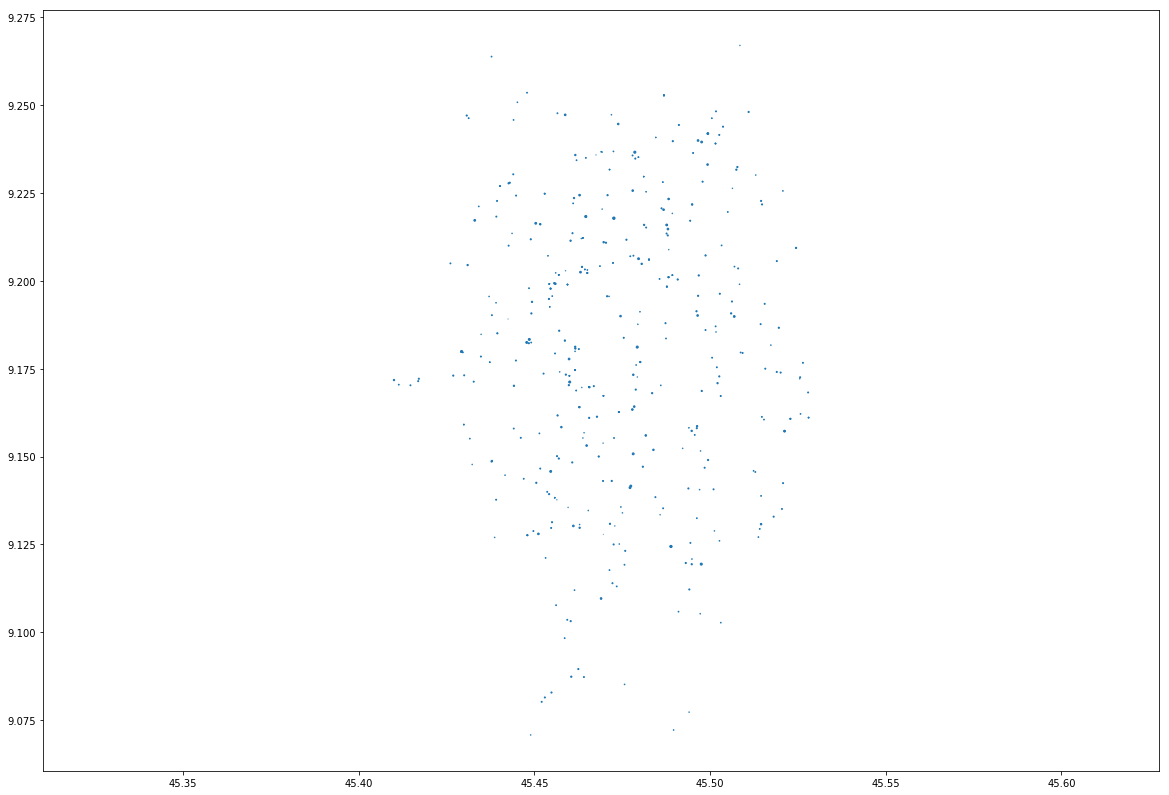

In [87]:
plotter = unitPlotter(schoolUnits)
plotter.plot_locations()

In [ ]:
### Demand modelling
class Household:
    def __init__(self, position=None, membersInput=None):
        # make defaults
        if not position: position = get_random_pos(1)
        if not membersInput: membersInput = {a: 1 for a in AgeGroup.all()}
        # expand input to all age group keys
        self.members = {a: membersInput.get(a, 0) for a in AgeGroup.all()}
        self.position = position
        self.export = pd.DataFrame(self.members, index=([self.position])) # precompute for speed

def evaluate_demand(householdList, outputServices= [t for t in ServiceType]):
    """ """
    # initialise output
    outDemand = dict()
    # consolidate positions. If two households share the same position, sum components.
    householdData = pd.concat([h.export for h in householdList])
    householdData['position'] = householdData.index 
    consolidated = householdData.groupby('position').sum()
    
    for thisServType in outputServices:
        outDemand[thisServType] = consolidated*thisServType.demandFactors
        
    return outDemand

In [ ]:
hhList =  [Household() for i in range(40)]
evaluate_demand(hhList)

In [ ]:
## Matching demand and supply
def get_satisfaction_indexes(householdList)